# CRYPTO PREDICTOR

In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import warnings
from lstm import LSTM

,Open,High,Low,Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


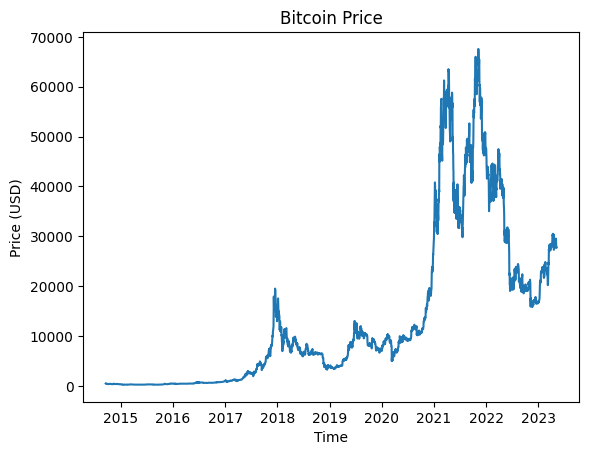

In [68]:
# read data and plot price in time
df = pd.read_csv('data/BTC-USD.csv', index_col='Date', parse_dates=True)
df.drop(columns='Adj Close', inplace=True)

display(df.head())

plt.plot(df['Close'])
plt.xlabel('Time')
plt.ylabel('Price (USD)')
plt.title('Bitcoin Price')
plt.show()

In [74]:
X = df.drop(columns=['Close'])
y = {"Close": df.Close.values, "Date": df.index.values}

# MinMaxScaler - scale data proportionally to the range of the data
min_max_scaler = MinMaxScaler()
y_standarized = min_max_scaler.fit_transform(y["Close"].reshape(-1, 1))

# StandardScaler - scale data to have a mean of 0 and a standard deviation of 1
standard_scaler = StandardScaler()
x_standarized = standard_scaler.fit_transform(X)

print(x_standarized)
print(y_standarized)

[[-0.80271459 -0.80287    -0.80422415 -0.84284687]
 [-0.80327593 -0.80355792 -0.80674862 -0.84216486]
 [-0.80531808 -0.80532272 -0.80858312 -0.84199029]
 ...
 [ 0.94191831  0.91146427  0.92021281  0.12745571]
 [ 0.8948254   0.86027634  0.92441619 -0.12623663]
 [ 0.89184148  0.8904432   0.90393611  0.12751872]]
[[0.00414359]
 [0.00365546]
 [0.00321557]
 ...
 [0.40832009]
 [0.40779333]
 [0.40885202]]


In [75]:
# create sequences from standarized data
def create_sequences(x_data, y_data, x_step, y_step):
    X, y = list(), list()
    for i in range(len(x_data)):
        x_end_idx = i + x_step
        y_end_ix = x_end_idx + y_step - 1
        if y_end_ix > len(x_data):
            break
        new_seq_x, new_seq_y = x_data[i:x_end_idx], y_data[x_end_idx-1:y_end_ix, -1]
        X.append(new_seq_x), y.append(new_seq_y)
    return np.array(X), np.array(y)

X_ss, y_mm = create_sequences(x_standarized, y_standarized, 100, 50)
print(X_ss.shape, y_mm.shape)

(3010, 100, 4) (3010, 50)


In [77]:
total_samples = len(X)
train_test_cutoff = round(0.90 * total_samples)

X_train = X_ss[:-150]
X_test = X_ss[-150:]

y_train = y_mm[:-150]
y_test = y_mm[-150:] 

print("Training Shape:", X_train.shape, y_train.shape)
print("Testing Shape:", X_test.shape, y_test.shape) 

Training Shape: (2694, 100, 4) (2694, 50)
Testing Shape: (316, 100, 4) (316, 50)


In [78]:
# convert to pytorch tensors
X_train_tensors = torch.Tensor(X_train)
X_test_tensors = torch.Tensor(X_test)

y_train_tensors = torch.Tensor(y_train)
y_test_tensors = torch.Tensor(y_test)

In [79]:
# reshaping to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors,   
                                      (X_train_tensors.shape[0], 100, 
                                       X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors,  
                                     (X_test_tensors.shape[0], 100, 
                                      X_test_tensors.shape[2])) 

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([2694, 100, 4]) torch.Size([2694, 50])
Testing Shape: torch.Size([316, 100, 4]) torch.Size([316, 50])


In [80]:
X_check, y_check = create_sequences(X, y['Close'].reshape(-1, 1), 100, 50)
display(X.shape, y['Close'].shape)

(3158, 4)

(3158,)

In [81]:
# Steps:
# 1. Set model to training mode
# 2. Feed the training data
# 3. Reset the gradients back to zero
# 4. Compute the loss for the training data
# 5. Backpropagate the loss
# 6. Update the parameters
# 7. Set model to evaluation mode
# 8. Feed the test data
# 9. Compute the loss for the test data

def training_loop(num_of_epochs, lstm: LSTM, optimiser, loss_fn, X_train, y_train, X_test, y_test):
    for epoch in range(num_of_epochs):
        lstm.train()
        outputs = lstm.forward(X_train)
        optimiser.zero_grad()
        loss = loss_fn(outputs, y_train)
        loss.backward()
        optimiser.step()
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch,
                                                                      loss.item(),
                                                                      test_loss.item()))


In [82]:
warnings.filterwarnings('ignore')

num_of_epochs = 500
learning_rate = 0.001

# number of features
input_size = 4

hidden_size = 64
num_layers = 1
num_classes = 50

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

loss_fn = torch.nn.MSELoss()

# Adam - Adaptive Moment Estimation
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [87]:
training_loop(num_of_epochs=num_of_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.00125, test loss: 0.02762
Epoch: 100, train loss: 0.00103, test loss: 0.02687
Epoch: 200, train loss: 0.00086, test loss: 0.03163
Epoch: 300, train loss: 0.00073, test loss: 0.03641
Epoch: 400, train loss: 0.00071, test loss: 0.03912


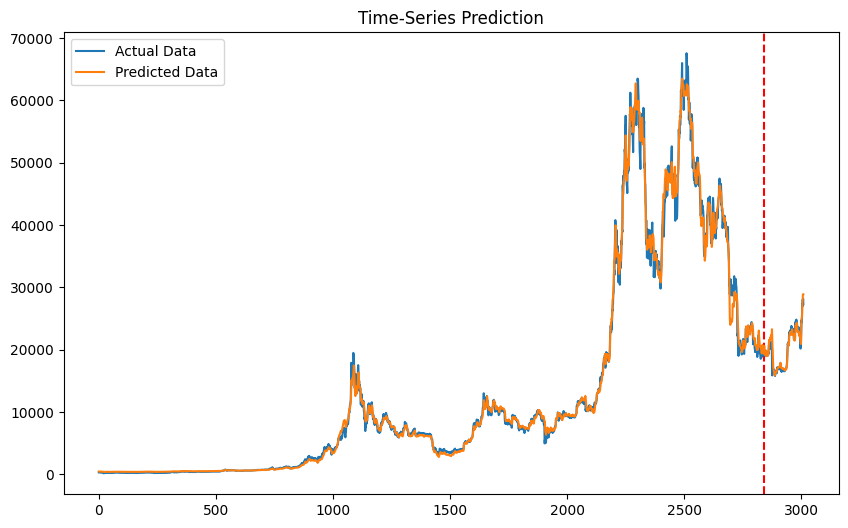

In [88]:
df_X_ss = standard_scaler.transform(df.drop(columns=['Close']))
df_y_mm = min_max_scaler.transform(df.Close.values.reshape(-1, 1))

df_X_ss, df_y_mm = create_sequences(df_X_ss, df_y_mm, 100, 50)

df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)

df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 100, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss)
data_predict = train_predict.data.numpy()
dataY_plot = df_y_mm.data.numpy()

data_predict = min_max_scaler.inverse_transform(data_predict)
dataY_plot = min_max_scaler.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
plt.figure(figsize=(10,6))
plt.axvline(x=train_test_cutoff, c='r', linestyle='--')

plt.plot(true, label='Actual Data')
plt.plot(preds, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

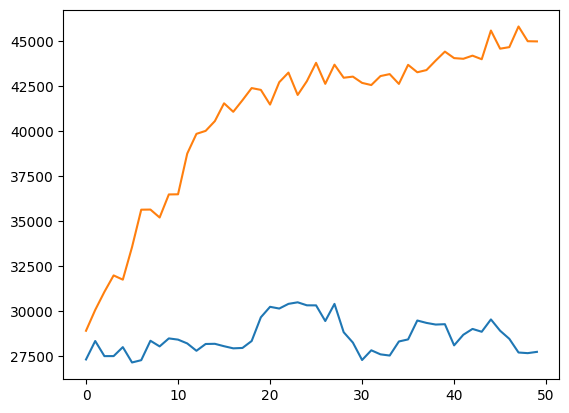

In [89]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0))
test_predict = test_predict.detach().numpy()
test_predict = min_max_scaler.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensors[-1].detach().numpy()
test_target = min_max_scaler.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label="Actual Data")
plt.plot(test_predict, label="LSTM Predictions")
plt.show()

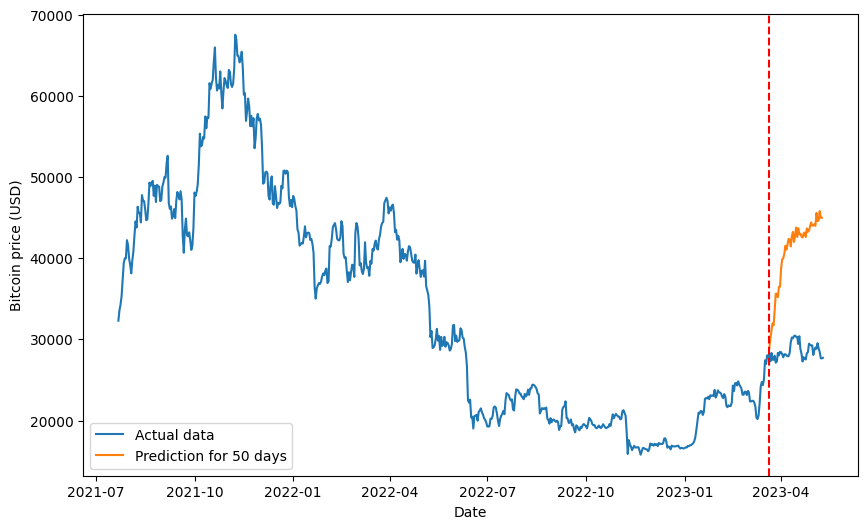

In [90]:
plt.figure(figsize=(10,6))

# 2500 is start index of test data
TEST_DATA_START_INDEX = 2500

start_date = y['Date'][TEST_DATA_START_INDEX]
last_date = y['Date'][-1]
num_days = len(y['Close']) - TEST_DATA_START_INDEX

# plot actual data
actual_date_range = pd.date_range(start=start_date, periods=num_days, freq='D')
plt.plot(actual_date_range, y['Close'][TEST_DATA_START_INDEX:], label='Actual data')

# plot predictions
prediction_date_range = pd.date_range(start=last_date - pd.Timedelta(days=50), periods=50, freq='D')
plt.plot(prediction_date_range, test_predict, label='Prediction for 50 days')

# plot vertical line to indicate start of predictions
plt.axvline(x=last_date - pd.Timedelta(days=50), c='r', linestyle='--')

plt.xlabel('Date')
plt.ylabel('Bitcoin price (USD)')
plt.legend()
plt.show()